# Naive Bayes

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Load the preprocessed dataset
dataset = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' and 'mental_health_issue' columns exist
if 'cleaned_text' not in dataset.columns or 'mental_health_issue' not in dataset.columns:
    raise ValueError("The dataset must have 'cleaned_text' and 'mental_health_issue' columns.")

# Remove rows with missing values in 'cleaned_text' column
dataset.dropna(subset=['cleaned_text'], inplace=True)

# Initialize the CountVectorizer and fit/transform the cleaned text
NBvectorizer = CountVectorizer()
X = NBvectorizer.fit_transform(dataset['cleaned_text'])

# Prepare the target variable
y = dataset['mental_health_issue']

# Split the dataset into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier
NBmodel = MultinomialNB()

# Fit the model
NBmodel.fit(X_train, y_train)

# Make predictions
y_pred = NBmodel.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform stratified cross-validation and compute accuracies
cross_val_accuracies = []
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]

    # Use .iloc to access data by position instead of label-based indexing
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    NBmodel.fit(X_train_fold, y_train_fold)
    fold_accuracy = NBmodel.score(X_test_fold, y_test_fold)
    cross_val_accuracies.append(fold_accuracy)

# Convert to NumPy array for consistency
cross_val_accuracies = np.array(cross_val_accuracies)

# Calculate mean and standard deviation
mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")

Accuracy: 83.63%
Classification Report:
               precision    recall  f1-score   support

     anxiety       0.70      0.73      0.72       379
     bipolar       0.83      0.45      0.58       384
  depression       0.59      0.87      0.70       373
      normal       0.96      0.92      0.94      2183
        ptsd       0.71      0.83      0.76       394

    accuracy                           0.84      3713
   macro avg       0.76      0.76      0.74      3713
weighted avg       0.85      0.84      0.84      3713

Confusion Matrix:
 [[ 278    4   63    3   31]
 [  30  171   62   86   35]
 [  26    6  323    0   18]
 [  38   21   68 2006   50]
 [  24    5   34    4  327]]
Cross-Validation Accuracies: [0.82359278 0.82467008 0.83463507 0.83705898 0.82520873]
Mean Validation Accuracy: 82.90%
Validation Accuracy Std Dev: 0.56%


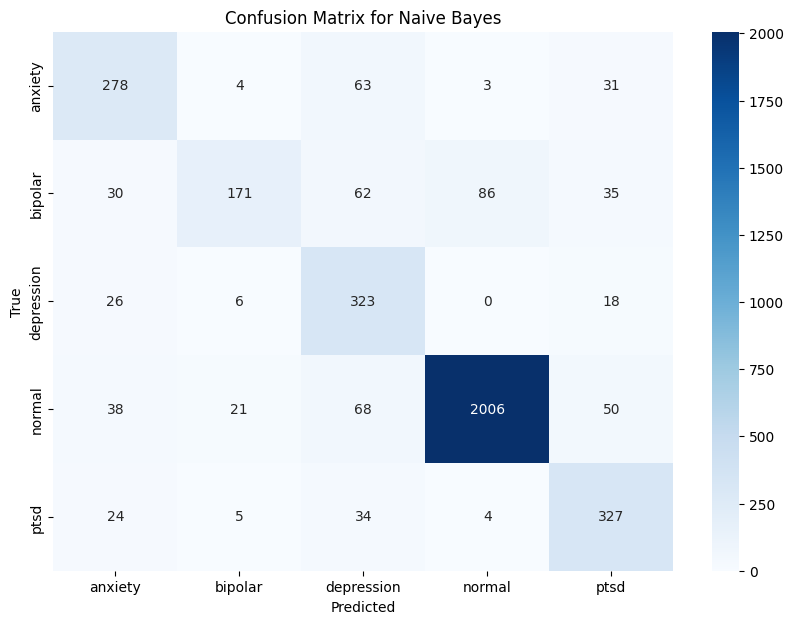

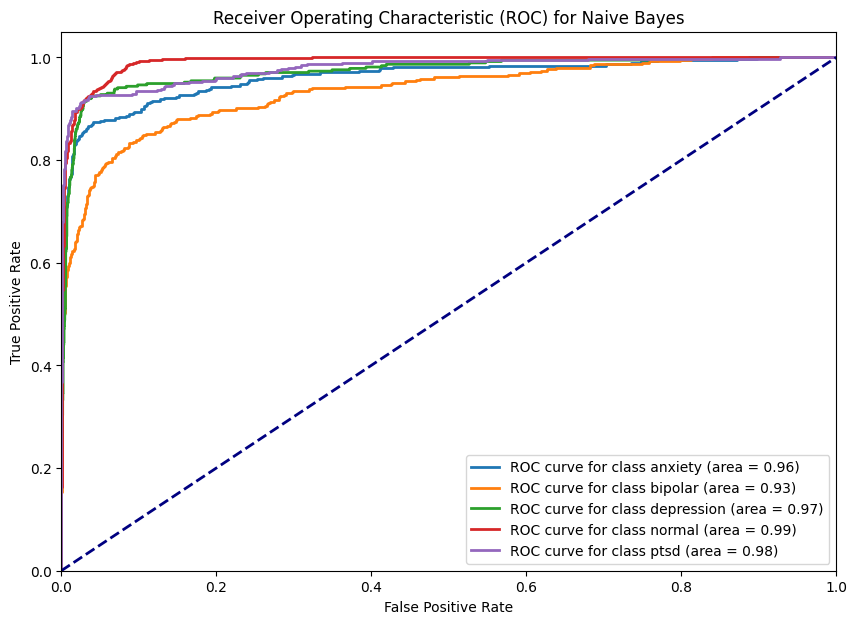

In [4]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=NBmodel.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=NBmodel.classes_, yticklabels=NBmodel.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

# ROC Curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC
y_test_binarized = label_binarize(y_test, classes=NBmodel.classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], NBmodel.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:0.2f})'.format(NBmodel.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Naive Bayes')
plt.legend(loc="lower right")
plt.show()